# Selecting simulation with an appropriate seasonality

As pointed out in the paper, performing the bias adjustment is challenging if the raw simulation has a late season start / early season end. For this reason, we pre-selected simulations that reproduce the seasonality of the reference reasonably well. 

To this end, we extracted many simulations and computed the `snow_season_start` and `snow_season_end` indicators.

This is just a reproduction of the analysis we made, we checked this with more simulations in the paper.
This example shows two simulations that would be rejected with our criteria

In [114]:
from xscen import DataCatalog, load_config,CONFIG
import importlib 
from pathlib import Path
import os 
from copy import deepcopy
from itertools import product

src_mods = []
r_mods = [("src." + m,m) for m in src_mods] + [("utils","u")]
cfgfiles = ['config/paths.yml', "config/config.yml", "config/schemas.yml"]

# load
modules = {short_key:importlib.import_module(mod_name) for mod_name,short_key in r_mods}
globals().update(modules)
load_config(*cfgfiles, verbose=(__name__ == '__main__'), reset=True)

def reload(mods=modules): 
    global CONFIG,cfg
    for mod in mods.values():
        importlib.reload(mod)
    load_config(*cfgfiles, verbose=(__name__ == '__main__'), reset=True)
    cfg = deepcopy(CONFIG)

pcat = DataCatalog(CONFIG["paths"]['project_catalog'])


## Getting the simulations

In [311]:
reload()
xrfreqs = set(pcat.search(processing_level="raw_indicators").df.xrfreq)
cat = pcat.search(processing_level="raw_indicators", type="simulation")
dsd =  {}
ref = xr.merge(pcat.search(processing_level="raw_indicators", type="reconstruction").to_dataset_dict().values())
for idd in cat.df.id: 
    ds0 = xr.merge(cat.search(id=idd).to_dataset_dict().values())
    newid = ds0.attrs["cat:experiment"] + "_" + ds0.attrs["cat:source"]
    dsd[idd] = ds0



--> The keys in the returned dictionary of datasets are constructed as follows:
	'id.domain.processing_level.xrfreq'


/exec/edupuis/.mamba/pins-8/lib/python3.13/site-packages/intake_esm/source.py:82: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.



--> The keys in the returned dictionary of datasets are constructed as follows:
	'id.domain.processing_level.xrfreq'


/exec/edupuis/.mamba/pins-8/lib/python3.13/site-packages/intake_esm/source.py:82: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.



--> The keys in the returned dictionary of datasets are constructed as follows:
	'id.domain.processing_level.xrfreq'


/exec/edupuis/.mamba/pins-8/lib/python3.13/site-packages/intake_esm/source.py:82: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.



--> The keys in the returned dictionary of datasets are constructed as follows:
	'id.domain.processing_level.xrfreq'


/exec/edupuis/.mamba/pins-8/lib/python3.13/site-packages/intake_esm/source.py:82: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.



--> The keys in the returned dictionary of datasets are constructed as follows:
	'id.domain.processing_level.xrfreq'


/exec/edupuis/.mamba/pins-8/lib/python3.13/site-packages/intake_esm/source.py:82: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.


## Compute the conditions

We compute the proportion of grid points with  
- `|sss_sim - sss_ref|<=10`
- `|sse_sim - sse_ref|<=15`

where (`sss=snw_season_start` and `sse=snw_season_end`). Simulations with a proportion of 80% or more grid points respecting these conditions were selected.

In [324]:
dsd0 = {}
for k in dsd.keys(): 
    dsd0[k] = (np.abs(dsd[k]-ref))[["snw_season_start", "snw_season_end"]]
    dsd0[k] = dsd0[k].assign_coords(quantization_info=[0]).drop("quantization_info")
    dsd0[k]["|sss_diff| <= 10"] = dsd0[k]["snw_season_start"] <= 10
    dsd0[k]["|sse_diff| <= 15"] = dsd0[k]["snw_season_end"] <= 15
    dsd0[k] = dsd0[k].drop(["snw_season_end","snw_season_start"])
dsd0 = {k:dsd0[k].mean().assign_coords(c=[0]).to_dataframe() for k in dsd0.keys()}
df = pd.concat(dsd0)

/tmp/ipykernel_76610/640905000.py:4: DeprecationWarning: dropping variables using `drop` is deprecated; use drop_vars.
/tmp/ipykernel_76610/640905000.py:7: DeprecationWarning: dropping variables using `drop` is deprecated; use drop_vars.
/tmp/ipykernel_76610/640905000.py:4: DeprecationWarning: dropping variables using `drop` is deprecated; use drop_vars.
/tmp/ipykernel_76610/640905000.py:7: DeprecationWarning: dropping variables using `drop` is deprecated; use drop_vars.


## Plot

Text(50.58159722222218, 0.5, '')

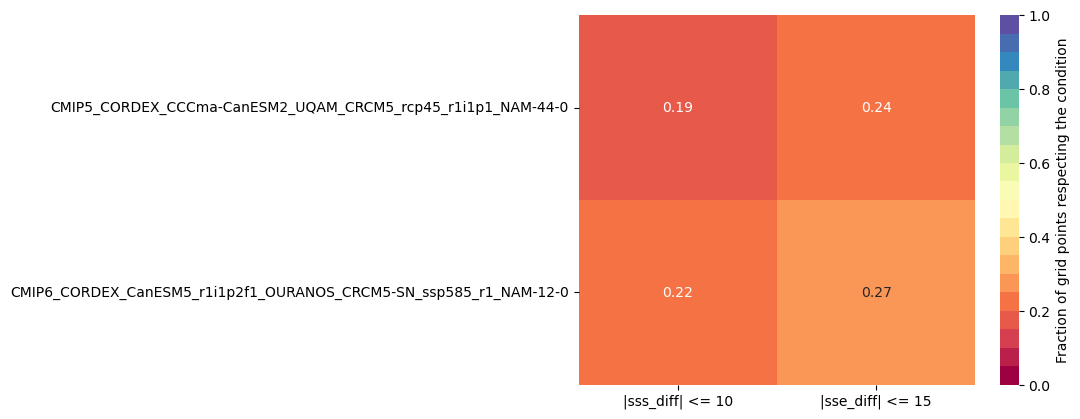

In [326]:
from matplotlib.colors import BoundaryNorm, ListedColormap
import matplotlib.pyplot as plt

fig, ax = plt.subplots()
cmap = sns.color_palette("Spectral", as_cmap=True)  # Example continuous colormap
num_levels = 20
boundaries = np.linspace(0, 1, num_levels + 1)
norm = BoundaryNorm(boundaries, ncolors=num_levels, clip=True)
discrete_cmap = ListedColormap(cmap(np.linspace(0, 1, num_levels)))
sns.heatmap(data=df,annot=True, cmap=discrete_cmap, vmin=0,vmax=1, cbar_kws={"label":"Fraction of grid points respecting the condition"}, ax=ax)
ax.set_yticklabels(ax.get_yticklabels(), rotation=0)
ax.set_ylabel("")